In [1]:
from utils import read_from_jsonl
train_data = read_from_jsonl("train.jsonl")
test_data = read_from_jsonl("test.jsonl")

In [2]:
train_data[0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'chunk_tags': [1, 1, 1, 0, 1, 1, 1, 0, 1],
 'pos_tags': [1, 4, 3, 1, 4, 4, 3, 1, 4]}

In [3]:
from copy import deepcopy
train_data_encoded = deepcopy(train_data)
test_data_encoded = deepcopy(test_data)

In [4]:
import numpy as np

curr_one_hot_encoding_mapping = {
    1: [1, 0, 0, 0],
    2: [0, 1, 0, 0],
    3: [0, 0, 1, 0],
    4: [0, 0, 0, 1]
}

prev_one_hot_encoding_mapping = {
    # 0 for start of string sequence
    0: [1, 0, 0, 0, 0],
    1: [0, 1, 0, 0, 0],
    2: [0, 0, 1, 0, 0],
    3: [0, 0, 0, 1, 0],
    4: [0, 0, 0, 0, 1]
}

for i, data in enumerate(train_data):
    for j, pos in enumerate(data["pos_tags"]):
        if j == 0:
            prev = prev_one_hot_encoding_mapping[0]
            curr = curr_one_hot_encoding_mapping[pos]
        else:
            prev = prev_one_hot_encoding_mapping[data["pos_tags"][j-1]]
            curr = curr_one_hot_encoding_mapping[pos]
        
        train_data_encoded[i]["pos_tags"][j] = np.array(prev + curr)
        

In [5]:
train_data_encoded[0]


{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'chunk_tags': [1, 1, 1, 0, 1, 1, 1, 0, 1],
 'pos_tags': [array([1, 0, 0, 0, 0, 1, 0, 0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 1, 0]),
  array([0, 0, 0, 1, 0, 1, 0, 0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 1, 0]),
  array([0, 0, 0, 1, 0, 1, 0, 0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 1])]}

In [6]:
for i in train_data_encoded:
    chunk_tags = np.array(i["chunk_tags"])
    i["chunk_tags"] = chunk_tags
    pos_tags = np.array(i["pos_tags"])
    pos_tags.reshape(1, pos_tags.shape[0], pos_tags.shape[1])
    i["pos_tags"] = pos_tags


In [7]:
train_data_encoded[0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'chunk_tags': array([1, 1, 1, 0, 1, 1, 1, 0, 1]),
 'pos_tags': array([[1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1]])}

In [8]:
for i in range(2):
    print(train_data_encoded[i]["pos_tags"].shape)
    print(train_data_encoded[i]["chunk_tags"].shape)

(9, 9)
(9,)
(2, 9)
(2,)


## Dataloader implementing Above things is in utils.py

In [11]:
from utils import read_from_jsonl
from utils import DataLoader
import matplotlib.pyplot as plt
train_data = read_from_jsonl("train.jsonl")
test_data = read_from_jsonl("test.jsonl")

train_data_loader = DataLoader(train_data[:1000], batch_size=len(train_data[:1000]))
test_data_loader = DataLoader(test_data, batch_size=32)

In [12]:
len(train_data), len(train_data_loader) 

(14041, 1000)

In [13]:
from utils import RecurrentPerceptron

a = RecurrentPerceptron(clip_grads=True, clip=1., verbose=False)
a.train_from_dataloader(train_data_loader, lr=0.05, nepochs=500, debug=False, print_interval=50)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 : Avg Loss : 0.47550347447395325
Epoch 50 : Avg Loss : 0.45367562770843506
Epoch 100 : Avg Loss : 0.45367446541786194
Epoch 150 : Avg Loss : 0.45367488265037537
Epoch 200 : Avg Loss : 0.45367512106895447
Epoch 250 : Avg Loss : 0.45367515087127686
Epoch 300 : Avg Loss : 0.4536750316619873
Epoch 350 : Avg Loss : 0.45367535948753357
Epoch 400 : Avg Loss : 0.4536752700805664
Epoch 450 : Avg Loss : 0.4536752700805664
Epoch 500 : Avg Loss : 0.4536752700805664


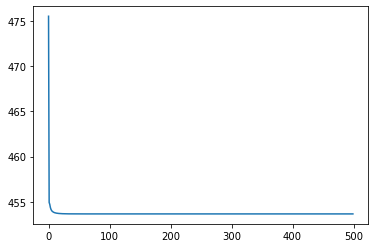

In [14]:
plt.plot(a.losslog)

In [16]:
a.check_conditions()

AttributeError: 'RecurrentPerceptron' object has no attribute 'check_conditions'

In [17]:
a.save_model()

File already exists, overwriting


In [18]:
thresh = 0.5
conditions = [
a.W[0] + a.W[-3] >= thresh,
a.W[0] + a.W[-2] >= thresh,
a.W[0] + a.W[-4] >= thresh,
a.W[0] + a.W[-1] >= thresh,
a.V + a.W[2] + a.W[-2] <= thresh,
a.V + a.W[2] + a.W[-4] <= thresh,
a.W[3] + a.W[-2] <= thresh,
a.W[3] + a.W[-4] <= thresh,
a.V + a.W[3] + a.W[-2] <= thresh,
a.V + a.W[3] + a.W[-4] <= thresh,
a.W[1] + a.W[-1] >= thresh,
a.V + a.W[1] + a.W[-1] >= thresh,
a.V + a.W[4] + a.W[-3] >= thresh,
a.V + a.W[4] + a.W[-2] >= thresh,
a.V + a.W[4] + a.W[-4] >= thresh,
a.V + a.W[4] + a.W[-1] >= thresh
]

In [19]:
conditions

[tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(False),
 tensor(True),
 tensor(False),
 tensor(False),
 tensor(True)]